## Weather Data : Visualization After Smoothing

### For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [5]:
!rm -r ../Data/Weather/NY.*
!ls ../Data/Weather

state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

rm: ../Data/Weather/NY.*: No such file or directory
STAT_NY.pickle       Weather_Stations.tgz stations.parquet


In [7]:
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0   850k      0  0:01:16  0:01:16 --:--:--  870k  0   681k      0  0:01:34  0:00:06  0:01:28  862k0     0   805k      0  0:01:20  0:00:19  0:01:01  867k6 29.6M    0     0   833k      0  0:01:17  0:00:36  0:00:41  866kM    0     0   843k      0  0:01:16  0:00:54  0:00:22  863k
-rw-r--r--  1 josem  staff    63M Nov  8 18:29 ../Data/Weather/NY.tgz


In [9]:
!ls -l $data_dir

total 232296
-rw-r--r--  1 josem  staff  66288146 Nov  8 18:29 NY.tgz
-rw-r--r--  1 josem  staff  51365103 Nov  8 18:12 STAT_NY.pickle
-rw-r--r--  1 josem  staff    353056 Nov  8 17:31 Weather_Stations.tgz
drwxr-xr-x  9 josem  staff       288 Apr 10  2018 stations.parquet


In [10]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/Users/josem/src/docencia/bde/Data/Weather
 76M	./NY.parquet
/Users/josem/src/docencia/bde/Section2-Weather-PCA


In [11]:
!du -h $data_dir/$parquet

 76M	../Data/Weather/NY.parquet


In [12]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

NY.parquet
number of rows= 168398


In [13]:
weather_df.show(1)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 1 row



### read statistics information for state.

In [14]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0   842k      0  0:00:36  0:00:36 --:--:--  868k.0M    0     0   793k      0  0:00:38  0:00:14  0:00:24  885k   0   840k      0  0:00:36  0:00:34  0:00:02  869k


In [15]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

../Data/Weather/STAT_NY.pickle.gz
-rw-r--r--  1 josem  staff  31373293 Nov  8 18:30 ../Data/Weather/STAT_NY.pickle.gz


In [16]:
print(gzpath)
!gunzip -f $gzpath
!ls -l $data_dir

../Data/Weather/STAT_NY.pickle.gz
total 232296
drwxr-xr-x  31 josem  staff       992 Apr 19  2018 NY.parquet
-rw-r--r--   1 josem  staff  66288146 Nov  8 18:29 NY.tgz
-rw-r--r--   1 josem  staff  51365103 Nov  8 18:30 STAT_NY.pickle
-rw-r--r--   1 josem  staff    353056 Nov  8 17:31 Weather_Stations.tgz
drwxr-xr-x   9 josem  staff       288 Apr 10  2018 stations.parquet


In [17]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))


In [18]:
Measurements = STAT.keys()
Measurements

dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])

In [19]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [17]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   447k      0 --:--:-- --:--:-- --:--:--  447k


In [18]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/home/jovyan/work/Sections/Data/Weather
77824	NY.parquet
1612	Weather_Stations.parquet
1888	decon_NY_SNWD.parquet
1888	recon_NY_SNWD.parquet
420	stations.parquet
/home/jovyan/work/Sections/Section2-Weather-PCA


In [20]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   

In [22]:
weather_df.join?

In [21]:
jdf=weather_df.drop('name').join(stations_df,on='Station',how='left')
jdf.show(3)

+-----------+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-------+
|    Station|Measurement|Year|              Values|       dist_coast|          latitude|         longitude|        elevation|state|Measurement|Year|              Values|       dist_coast|          latitude|         longitude|        elevation|state|   name|
+-----------+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-------+
|USC00303955|   SNOW_s20|1992|[00 00 00 00 00 0...|362.2770080566406|42.791900634765625|-77.51360321044922|243.8000030517578|   NY|   SNOW_s20|1992|[00 00 00 00 00 0...|362.2770080566406|42.791900634765625|-77.51360321044922|2

In [23]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+--------------------+-------+
|                Name|  count|
+--------------------+-------+
|     SETAUKET STRONG|2067844|
|NEW YORK CNTRL PK...|2044900|
|            LOWVILLE|1988100|
|              ELMIRA|1982464|
|            ANGELICA|1976836|
+--------------------+-------+
only showing top 5 rows



In [26]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

AnalysisException: "Reference 'Measurement' is ambiguous, could be: jdf.Measurement, jdf.Measurement.; line 5 pos 9"

In [24]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

NameError: name 'stat' is not defined

In [25]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

NameError: name 'stat' is not defined

## Plots

In [26]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

['TOBS', 'PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']

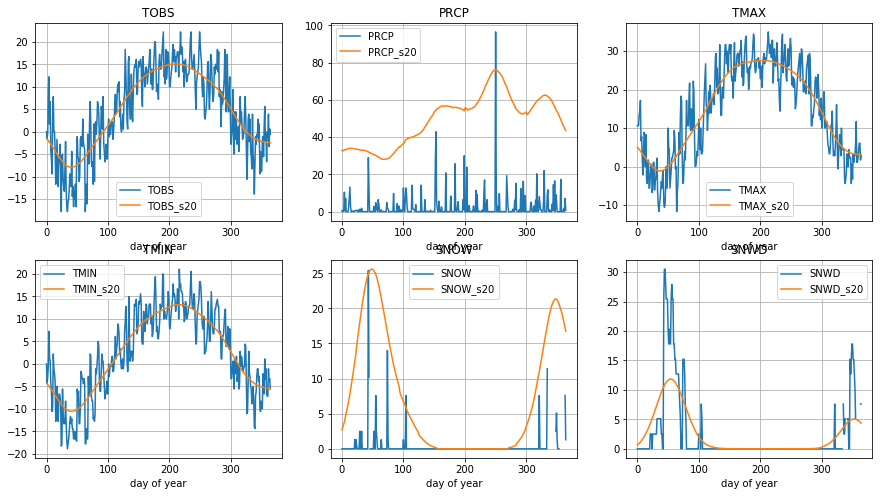

In [27]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [28]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

### Plots of mean and std of observations

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [30]:
from lib.MultiPlot import *

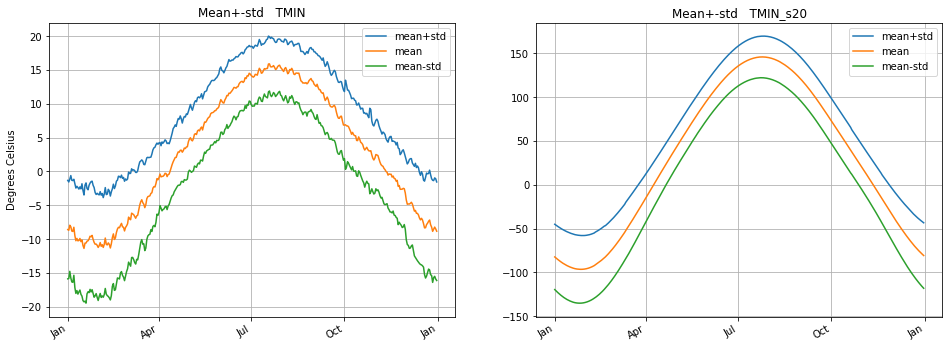

In [31]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

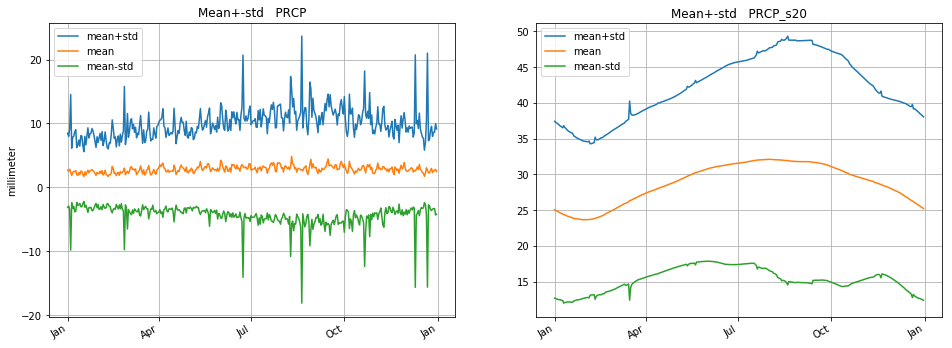

In [32]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

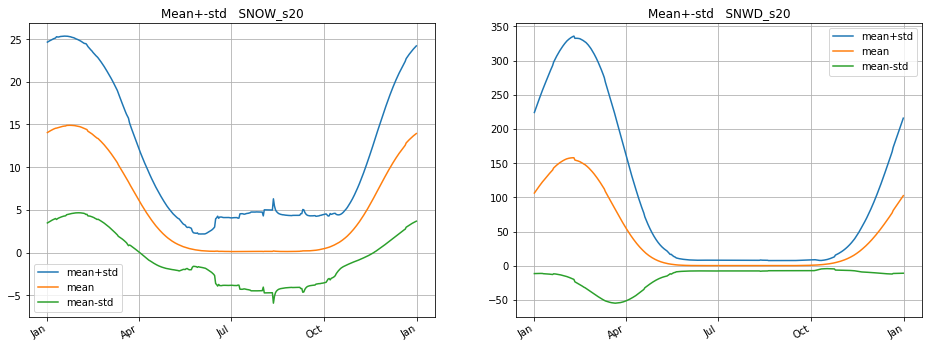

In [33]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [34]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [35]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: cannot create directory ‘r_figures’: File exists


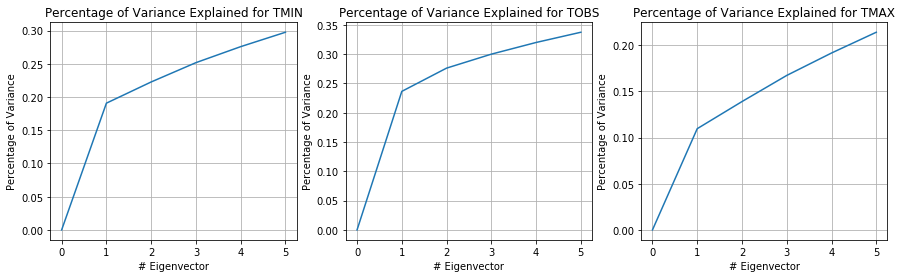

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

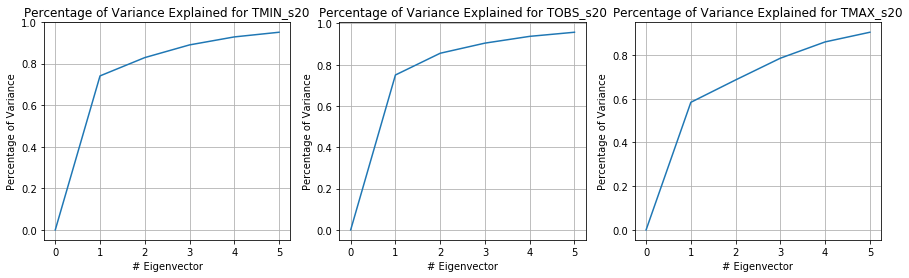

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

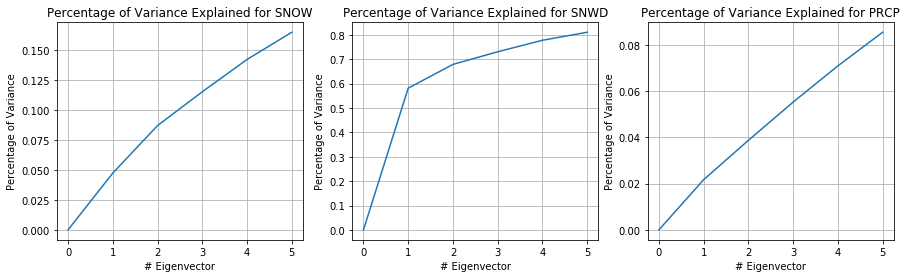

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

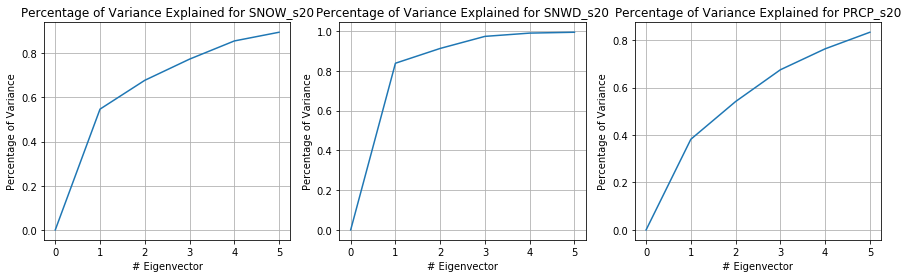

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### plotting top 3 eigenvectors

In [40]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

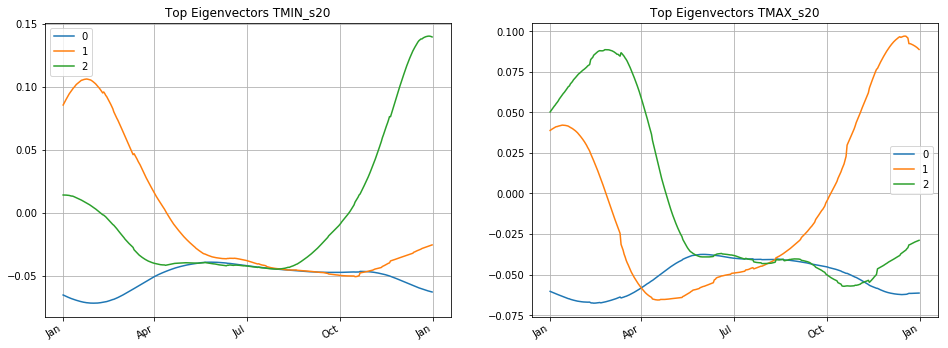

In [41]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

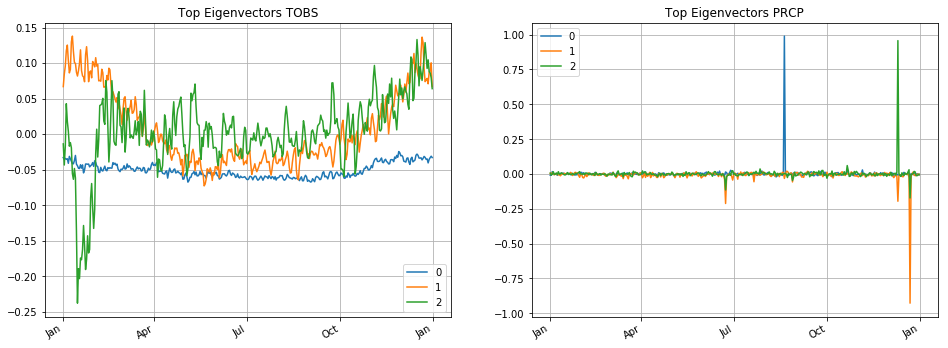

In [42]:
plot_pair(['TOBS','PRCP'],plot_eigen)

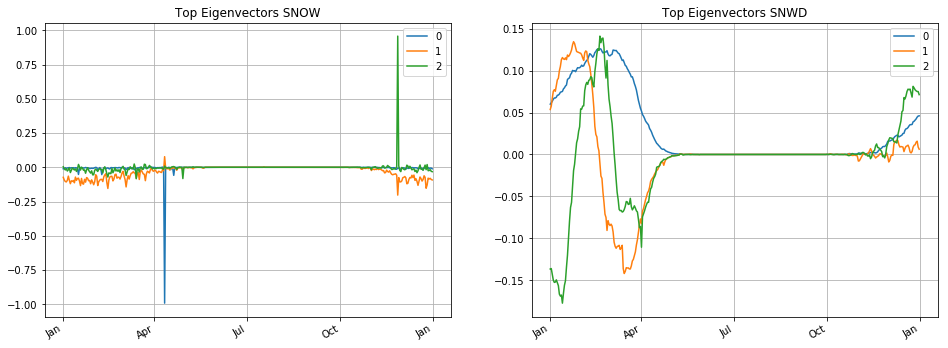

In [43]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of variance explained by top eigen-vectors.
* The top eigen-vectors